# **Drawdown Analysis**
## **No Name Dam**
___
**Date**: 2022-XX-XX <br>
**By**: Engineer <br>

### **References**
* USBR Design of Small Dams (1987), Chapter 10, Section 10.14 Pressure Flow in Outlet Conduits

### **Implementation Notes**
* A simple `DrawDownAnalysis` class was authored in `python` to facilitate the drawdown analysis and sensitivity analysis, based on the USBR procedures
* This implementation uses the `diameter` (or `area`) and equivalent loss coefficient (`K_eq`) to characterize the drawdown function/discharge of a single outlet
* The key discharge/drawdown function is give by **Section 10, Eq. 8**, where, $Q$ is the discharge, $K_{eq}$ is the equivalent loss coefficient, $A$ is the outlet area, $g$ is the gravitational constant, and $H_T$ is the total head measured from the resevoir pool to the centerline of the outlet: 
$$
\begin{align}
    Q=A\sqrt{\frac{2\cdot g\cdot H_T}{K_{eq}}}
\end{align}
$$
* A multiplier (`N_mult`) is provided to scale the discharge for additional outlets (e.g., use `N_mult=2` for two identically sized outlets)

### **Assumptions**
* Full Conduit (Pressure) Flow (Section 10 applicable)
* Total Outlet Length (each) = 50 ft
* Capacity-area curves from files (from files, 1977, may be inaccurate due to historical siltation)
* Key Elevations
    * Maximum Certified Pool @ el. 2224 ft
    * Dam Heel at Upstream @ el. 2080 ft
    * Maximum Resevoir Head = 2224 ft - 2080 ft = 144 ft
    * 10% Maximum Resevoir Head = 0.10(144 ft) = 14.4 ft
    * Final Drawdown (10% in 7 days) @ 2224 - 14.4 = el. 2209.6 ft
    * Low Level Outlet CL @ el. 2139 ft
    * Low Level Inlet CL @ el. 2140 ft (existing)
    * Riser Height (vertical) = 14.85 ft
    * Riser Top Elevation @ el. 2154.85 ft
    * Max Initial Head (w.r.t. to inlet) = 2224 ft – 2139 ft = 85 ft
* Loss Model and Coefficients

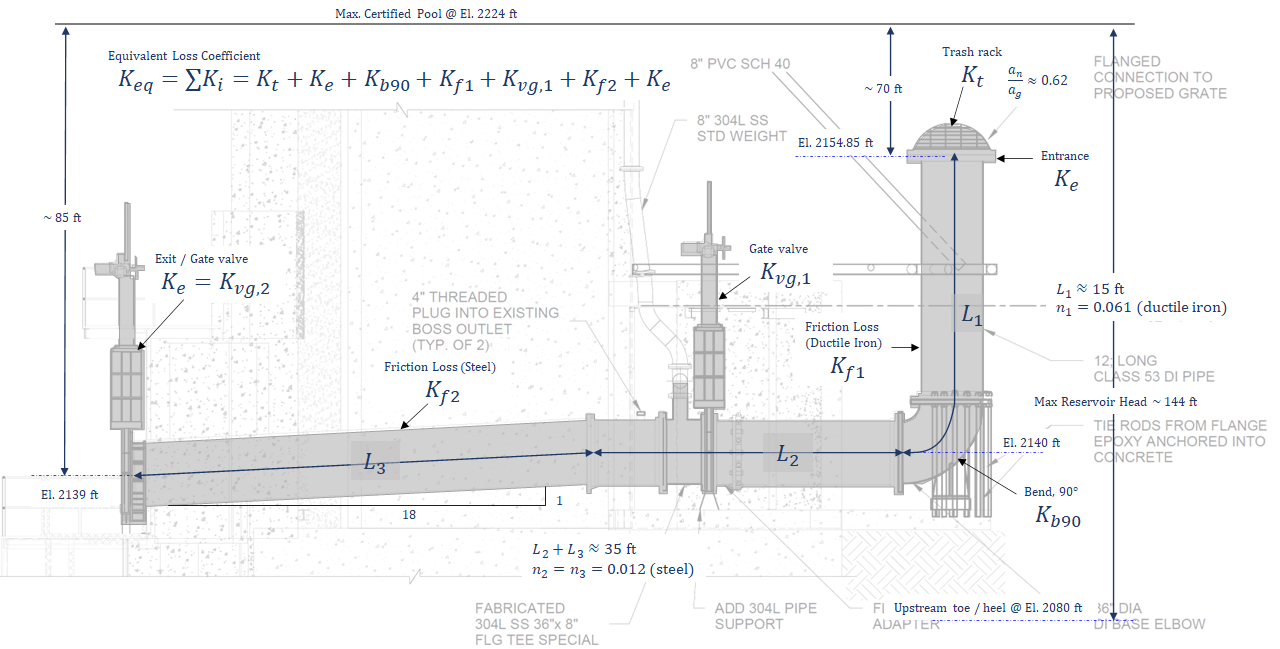

In [1]:
from IPython.display import Image
display(Image(filename='assets/loss-model.png', width=800))

|Element|Loss Type|Variable|Value|Expression/Notes|Reference|
|:-------|:-------|:-------|-------|-------|:-------|
|Trash rack|Trash rack|$K_t$|0.79|$K_t=1.45-0.45\frac{a_n}{a_g}-(\frac{a_n}{a_g})^2$ with $\frac{a_n}{a_g}$=0.62|Chapter 10, 10.15(c), Eq.11|
|Inlet|Entrance Losses|$K_e$|0.23|$\frac{1}{C^2}-1$ using $C=0.23$ (rounded entrance)|Chapter 10, 10.15(d), Table 10.1|
|Ductile Iron Pipe|Pipe Friction|$K_{f1}$|0.22|$29.1\cdot n^2 (L/r_h^{1.25})$ using $n=0.012$ (steel) and $L=15$ ft|Chapter 10, 10.15(a), Eq.10|
|90 Degree Vertical Bend|Pipe Bends (90$^\circ$ Vert.)|$K_{b,90}$|1.0|Chart solution assuming 90 $^\circ$ bend|Chapter 10, 10.15(e), Fig 10-12|
|Upstream Gate Valve|Gates Valve|$K_{gv}$|0.10|0.1 (upstream gate valve, fully open)|Chapter 10, 10.15(g)|
|Steel Pipe|Pipe Friction|$K_{f2}$|2.38|$29.1\cdot n^2 (L/r_h^{1.25})$ using $n=0.061$ (ductile iron) and $L=35$ ft|Chapter 10, 10.15(a), Eq.10|
|Outlet|Exit|$K_{e}$|0.10|0.1 (downstream gate valve, fully open)|Chapter 10, 10.15(g)|
|LLOV System|Total Equivalent|$K_{eq}$|4.82|$K_t$ + $K_f$ + $K_e$ + $K_{gv}$ + $K_{b,90}$|Chapter 10, 10.15(c), Eq.11|

In [3]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
from datetime import datetime

# pandas table formatting
pd.options.display.float_format = "{:,.2f}".format

## **Class Implementation**

In [16]:
class DrawDownAnalysis:
    """
    Class for performing drawdown analysis of dams with outlet parameters
    """
    # constants and unit conversions
    GRAVITY = 32.2 # ft/s/s
    CUBIC_FT_TO_ACRE_FT = 1/43559.9
    CFS_TO_ACREFT_PERHOUR = 0.08264462912563
    
    def __init__(self, dt=1, n_steps=1200):
        """ Constructor Function
        dt - time step [hrs]
        n_steps - number of analysis steps
        """
        # analysis settings
        self.dt = dt
        self.n_steps = n_steps
        
        # initialize variables
        self.drawdown_elev = None
        self. N_mult = None
        self.diam = None
        self.K_eq = None
        self.area = None
        self.radius_h = None
        
        # initialize tables
        self.df_results = pd.DataFrame()
        self.df_capacity = pd.DataFrame()
        self.df_area = pd.DataFrame()
        
    def assignOutletParams(self, N_mult, diam, K_eq):
        """ Assign outlet parameters
        N_mult - multipler for number of outlets of identical configuration
        diam - pipe diameter [ft]
        L - length of outlet [ft]
        K_eq - equivalent coefficient for losses
        """
        self. N_mult = N_mult
        self.diam = diam
        self.K_eq = K_eq
        self.area = (np.pi/4)*diam**2
        self.radius_h = self.area/(np.pi*diam) # hydraulic radius = area/perimeter
        return
    
    def assignResevoirParams(self, elev_o, H_o):
        """ Assign resevoir parameters
        elev_o - initial elevation (max certified pool) [ft]
        H_o - initial head (max head from max certified pool to outlet CL) [ft]
        """
        self.elev_o = elev_o
        self.H_o = H_o
        return
    
    def assignAreaCapacityCurves(self, path_area, path_cap):
        """
        path_area - path to area-elev curve csv file: area,elev [acres,ft]
        path_cap - path to capacity-elev curve csv file: capacity,elev [acre-ft,ft]
        """
        self.df_area = pd.read_csv(path_area)
        self.df_capacity = pd.read_csv(path_cap)
        return
    
    def assignDrawDownTargetElev(self, elev, note=""):
        """
        elev - target drawdown elevation (ft)
        note - note describing the drawdown criteria, e.g. "10% resevoir head in 7 days"
        """
        self.drawdown_elev = elev
        return
    
    def runDrawdownAnalysis(self):
        """ Drawdown analysis routine
        """
        
        def discharge(H_T, A, K_eq):
            """ Chapter 10, Section 10.14, Eq. 8
            H_T - Total head to overcome losses to produce discharge [ft]
            A - area of pipe [ft^2]
            K_eq - equivalent losses
            """
            Q = A*np.sqrt((2 * self.GRAVITY * H_T)/K_eq)
            return Q
        
        # initialize arrays
        time = np.arange(1, self.n_steps + 1) * self.dt
        elev = np.zeros(self.n_steps)
        head = np.zeros(self.n_steps)
        storage_initial = np.zeros(self.n_steps)
        storage_final = np.zeros(self.n_steps)
        Q = np.zeros(self.n_steps)
        V = np.zeros(self.n_steps)
        dVol = np.zeros(self.n_steps)

        # apply initial conditions
        elev[0] = self.elev_o
        head[0] = self.H_o
        storage_initial[0] = np.interp(self.elev_o,                           # Get initial storage from capacity-curve based on initial elev
                                       self.df_capacity['elev-ft'], 
                                       self.df_capacity['storage-acre-ft'])

        # Perform the n steps of discharge calculations
        for i in range(self.n_steps):

            # Skip for first time step
            if i > 0:
                # The new storage is the final storage of the last time step
                storage_initial[i] = storage_final[i-1]

                # Read the new elevation from the capacity-elev. curve
                elev[i] = np.interp(storage_final[i-1], 
                                    self.df_capacity['storage-acre-ft'], 
                                    self.df_capacity['elev-ft'])

                # Update the head based on the change in elevation
                head[i] = head[i-1] + (elev[i] - elev[i-1])  

            # Discharge (cfs)
            if head[i] > 0: # discharge is positive so long as head is positive
                Q[i] = N_mult * discharge(head[i], self.area, self.K_eq)
                Q[i] = max(0, Q[i]) # flow must be non-negative

            # Velocity (ft/s)
            V[i] = Q[i]/self.area

            # Change in volume (in acre-ft)
            dVol[i] = (Q[i] * self.CFS_TO_ACREFT_PERHOUR)/self.dt

            # Compute the final storage (in acre-ft)
            storage_final[i] = storage_initial[i] - dVol[i]
    
        # Create a dataframe for output
        df = pd.DataFrame(data={'time(days)':time/24,
                                'elev(ft)':elev, 
                                'head(ft)':head,
                                'storage_initial(acre-ft)':storage_initial,
                                'Q(cfs)':Q, 
                                'V(ft/s)':V,
                                'dVol(acre-ft)':dVol,
                                'storage_final(acre-ft)':storage_final
                               })
        self.df_results = df
        return
    
    def plotDrawdown(self, key_x=None, key_y=None):
        """ Plot drawdown analysis
        key_x = optional key for independent variable
        key_y = optional key for dependent variable
        """
        if not self.df_results.empty:
            if not key_x and not key_y:  
                key_x = self.df_results.columns[0]
                key_y = self.df_results.columns[3]
            try:
                fig, ax = plt.subplots()
                ax.plot(self.df_results[key_x]/24, self.df_results[key_y])
                ax.set_xlabel('Time (days)')
                ax.set_ylabel('Storage (acre-ft)')
                ax.grid(which='both', alpha=0.2)
                ax.set_xlim(left=0, right = max(self.df_results[key_x]/24))
                ax.set_ylim(bottom=0)
                plt.show()
            except:
                print("invalid keys specified for plotting. valid fields are:", ', '.join(self.df_results.columns)) 
        return
    
    def plotAreaCapacity(self):
        """ Plot the capacity-area vs elevation curves
        """
        if not self.df_capacity.empty and not self.df_area.empty:
            fig, ax = plt.subplots(1, 2, figsize=(12, 4))
            ax[0].plot(self.df_area['area-acres'], self.df_area['elev-ft'])
            ax[1].plot(self.df_capacity['storage-acre-ft'], self.df_capacity['elev-ft'])
            ax[0].set_xlabel('Area (acres)')
            ax[1].set_xlabel('Storage (acre-ft)')
            [a.set_ylabel('Elevation (ft)') for a in ax]
            [a.grid(which='both', alpha=0.2) for a in ax]
            [a.set_xlim(left=0) for a in ax]
            for x, a in zip(['Resevoir Area Curve', 'Resevoir Capacity Curve'],ax): a.set_title(x)
        return
    
    def getStorageAtElev(self, elev):
        """ Interpolates the elevation from capacity-elev curve
        """
        if not self.df_capacity.empty:
            storage = np.interp(elev, self.df_capacity['elev-ft'], self.df_capacity['storage-acre-ft'])
            return storage
    
    def saveResultsToCSV(self, tag="drawdown-analysis"):
        """ Save the results to a .csv file
        """
        if not self.df_results.empty:
            self.df_results.to_csv(f"{str(datetime.now().date())}" + f"-{tag}.csv")
        return
    
    def summarize(self, verbose=True):
        """ Report time to 10% reduction in max certified to heel of dam, and time to drained resevoir
        verbose - if true, prints statements
        """
        if not self.df_results.empty:
            mask_10percH = self.df_results['elev(ft)'] < elev_drawdown
            drained_index = self.df_results['dVol(acre-ft)'][self.df_results['dVol(acre-ft)'] == 0].index[0]
            t_10percH = self.df_results[mask_10percH]['time(days)'].iloc[0]
            t_drained = self.df_results['time(days)'].loc[drained_index]
            if verbose:
                print(f"Time at which 10% head is reduced: {t_10percH:.2f} days" )
                print(f"Time at which resevoir is drained: {t_drained:.2f} days" )
        return t_10percH, t_drained
    
    def display_table(self, elev=None):
        """ Display table results
        elev - target elevation to center table [ft]; if None, returns table to drawdown
        """
        if elev:
            mask = Analysis.df_results['elev(ft)'] < elev
            print(f"Elevation reached at index: {Analysis.df_results[mask].index[0]}")
            return Analysis.df_results[Analysis.df_results[mask].index[0]-5:].head(10)
        else:
            drained_index = Analysis.df_results['dVol(acre-ft)'][Analysis.df_results['dVol(acre-ft)'] == 0].index[0]
            print(f"Zero discharge reached at index: {drained_index}")
            return Analysis.df_results.head(drained_index + 1)

## **Inputs**

In [17]:
# outlet parameters
N_mult = 2                # Two (2) low-level outlets
diam = 36/12              # 36" diameter outlets
L1 = 35                   # Length of steel portion of outlet
L2 = 15                   # Lenth of iron portion of outlet
n1 = 0.012                # Manning's roughness coefficient for steel (max)
n2 = 0.061                # Manning's roughness coefficient for ductile iron (typ)

radius_h = diam/4                              # Hydraulic radius = area/(wetted perimeter)
K_f1 = 29.1*(n1**2)*(L1/(radius_h**(4/3)))     # Loss due to pipe friction in steel
K_f2 = 29.1*(n2**2)*(L2/(radius_h**(4/3)))     # Loss due to pipe friction in ductile iron
K_f = K_f1 + K_f2                              # Total loss

area_ratio = 0.62                              # Ratio of net through area to new trashrack area
K_t = 1.45-0.45*(area_ratio)-(area_ratio)**2   # Loss due to trash rack
K_e = 0.23                                     # Loss due to entrance
K_gv = 0.10 + 0.10                             # Loss due to 2 gate valves (US + DS exit)
K_b90 = 1.0                                    # Loss due to vertical 33-deg bend

K_eq = K_f + K_t + K_e + K_gv + K_b90     # Equivalent loss coefficient

# resevoir parameters
elev_o = 2224              # Starting elevation (max certified pool)
H_o = 85                   # Initial head (max certified pool - elevation at downstream outlet)
elev_drawdown = 2209.6     # final drawdown elevation to satisfy Division requirements (just for plotting, and table query)

# area/capacity curves
path_area = r"./area-capacity-curve/elev-area-curve-1977.csv"
path_cap = r"./area-capacity-curve/elev-storage-curve-1977.csv"

In [18]:
K_f2

2.38357543086856

In [19]:
pd.DataFrame(data={'Loss':['Friction $K_f$', 'Trash Rack $K_t$',  'Entrance $K_e$', 'Gate Valves $K_{gv}$', 'Bend 90 $K_{b90}$', 'Equivalent $K_{eq}$'], 
                   'Value':[K_f, K_t, K_e, K_gv, K_b90,  K_eq]})

,Loss,Value
0,Friction $K_f$,2.60
1,Trash Rack $K_t$,0.79
2,Entrance $K_e$,0.23
3,Gate Valves $K_{gv}$,0.20
4,Bend 90 $K_{b90}$,1.00
5,Equivalent $K_{eq}$,4.82


## **Analysis**

In [20]:
Analysis = DrawDownAnalysis(dt=1, n_steps=1100)

Analysis.assignOutletParams(N_mult, diam, K_eq)

Analysis.assignResevoirParams(elev_o, H_o)

Analysis.assignAreaCapacityCurves(path_area, path_cap)

Analysis.assignDrawDownTargetElev(elev_drawdown, note="10% resevoir head in 7 days")

Analysis.runDrawdownAnalysis()

Analysis.saveResultsToCSV()

In [21]:
Analysis.display_table()

Zero discharge reached at index: 223


,time(days),elev(ft),head(ft),storage_initial(acre-ft),Q(cfs),V(ft/s),dVol(acre-ft),storage_final(acre-ft)
0,0.04,"2,224.00",85.00,"6,140.00",476.65,67.43,39.39,"6,100.61"
1,0.08,"2,223.70",84.70,"6,100.61",475.80,67.31,39.32,"6,061.29"
2,0.12,"2,223.39",84.39,"6,061.29",474.95,67.19,39.25,"6,022.03"
3,0.17,"2,223.09",84.09,"6,022.03",474.10,67.07,39.18,"5,982.85"
4,0.21,"2,222.81",83.81,"5,982.85",473.29,66.96,39.11,"5,943.74"
...,...,...,...,...,...,...,...,...
219,9.17,"2,140.25",1.25,30.98,57.76,8.17,4.77,26.20
220,9.21,"2,139.82",0.82,26.20,46.83,6.63,3.87,22.33
221,9.25,"2,139.43",0.43,22.33,34.04,4.82,2.81,19.52
222,9.29,"2,139.15",0.15,19.52,20.17,2.85,1.67,17.85


In [22]:
Analysis.display_table(elev=elev_drawdown)

Elevation reached at index: 49


,time(days),elev(ft),head(ft),storage_initial(acre-ft),Q(cfs),V(ft/s),dVol(acre-ft),storage_final(acre-ft)
44,1.88,"2,210.94",71.94,"4,473.19",438.51,62.04,36.24,"4,436.95"
45,1.92,"2,210.64",71.64,"4,436.95",437.59,61.91,36.16,"4,400.79"
46,1.96,"2,210.34",71.34,"4,400.79",436.67,61.78,36.09,"4,364.70"
47,2.00,"2,210.04",71.04,"4,364.70",435.75,61.65,36.01,"4,328.69"
48,2.04,"2,209.72",70.72,"4,328.69",434.76,61.51,35.93,"4,292.76"
49,2.08,"2,209.39",70.39,"4,292.76",433.75,61.36,35.85,"4,256.91"
50,2.12,"2,209.06",70.06,"4,256.91",432.75,61.22,35.76,"4,221.15"
51,2.17,"2,208.76",69.76,"4,221.15",431.81,61.09,35.69,"4,185.46"
52,2.21,"2,208.46",69.46,"4,185.46",430.89,60.96,35.61,"4,149.85"
53,2.25,"2,208.17",69.17,"4,149.85",429.97,60.83,35.53,"4,114.31"


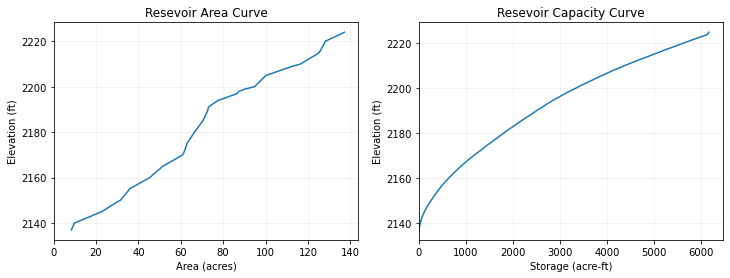

In [11]:
Analysis.plotAreaCapacity()

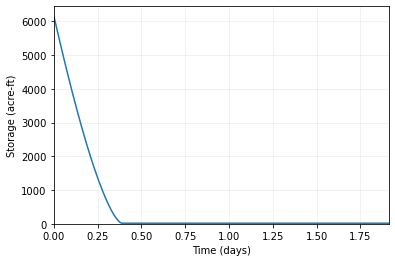

In [23]:
Analysis.plotDrawdown()

In [24]:
_, _, = Analysis.summarize()

Time at which 10% head is reduced: 2.08 days
Time at which resevoir is drained: 9.33 days


### **Sensitivity Analysis**

Repeat the analysis for equivalent losses of 125%, 150%, 200%, 500%, and 1000% of the baseline value.

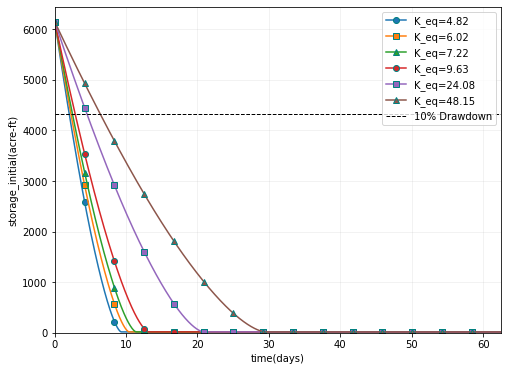

In [25]:
K_sensitivity = np.array([1.0, 1.25, 1.5, 2.0, 5.0, 10.0])*K_eq
analyses = [] 
time_drawdowns = [] 
time_drained = []
for i, k in enumerate(K_sensitivity):
    a = DrawDownAnalysis(dt=1, n_steps=1500)
    a.assignOutletParams(N_mult, diam, k)
    a.assignResevoirParams(elev_o, H_o)
    a.assignAreaCapacityCurves(path_area, path_cap)
    a.runDrawdownAnalysis()
    t10, tdrain = a.summarize(verbose=False)
    time_drawdowns.append(t10)
    time_drained.append(tdrain)
    analyses.append(a)
    
from itertools import cycle
symbols = cycle(['o','s','^'])
x, y = 'time(days)', 'storage_initial(acre-ft)'
t_max = analyses[0].df_results['time(days)'].max()

fig = plt.figure(figsize=(8,6))
for ai in analyses:
    plt.plot(ai.df_results[x], 
             ai.df_results[y],
             marker=next(symbols),
             markevery=100, 
             markeredgecolor='teal',
             label=f'K_eq={ai.K_eq:.2f}')
plt.plot([0, t_max],
         np.ones(2)*ai.getStorageAtElev(elev_drawdown),
         'k--', lw=1.0,
         label='10% Drawdown')

plt.grid(which='both',alpha=0.2)
plt.xlabel(x), plt.ylabel(y)
plt.xlim(left=0, right=t_max), plt.ylim(bottom=0)
plt.legend(loc='upper right')
plt.show()

In [15]:
pd.DataFrame(data={'Sensitivity ($K/K_{eq}$)': K_sensitivity/K_eq, 
                '$K$':K_sensitivity, 
                   '$t_{10\%}$ (days)':time_drawdowns,
                   '$t_{drain}$ (days)':time_drained
                  })

,Sensitivity ($K/K_{eq}$),$K$,$t_{10\%}$ (days),$t_{drain}$ (days)
0,1.00,4.82,2.08,9.33
1,1.25,6.02,2.33,10.46
2,1.50,7.22,2.54,11.46
3,2.00,9.63,2.92,13.25
4,5.00,24.08,4.58,20.96
5,10.00,48.15,6.46,29.62
